In [306]:
import graphistry
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from collections import Counter

import matplotlib.pylab as plt

from joblib import load, dump

import spacy
import warnings
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="..", password="..") 

In [4]:
g = graphistry.bind()

In [510]:
# df = pd.read_csv('~/Downloads/instances.csv')
# names = df.columns
# df2 = pd.read_csv('~/Downloads/instances 2.csv', names=names)
# df3 = pd.read_csv('~/Downloads/instances 3.csv', names=names)
# df4 = pd.read_csv('~/Downloads/instances 4.csv', names=names)
# df5 = pd.read_csv('~/Downloads/instances 5.csv', names=names)
# df6 = pd.read_csv('~/Downloads/instances 6.csv', names=names)
# mdf = pd.concat([df, df2, df3, df4, df5, df6], ignore_index=True)
# mdf = mdf.drop_duplicates(ignore_index=True)
# mdf['n'] = range(len(mdf))
# mdf.to_csv('data/darkweb.csv')

In [ ]:
# Now we have a total df we can load

In [322]:
df = pd.read_csv('data/darkweb.csv', index_col=0)

In [323]:
df=df.fillna('')

In [324]:
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df = df.sort_values(by='published_date', ascending=True, ignore_index=True)

In [266]:
df.columns

Index(['event_type', 'fragment', 'start_date', 'end_date', 'precision',
       'published_date', 'publication_time', 'document_title', 'document_id',
       'document_url', 'document_authors', 'source', 'source_topic',
       'source_media_type', 'event_id', 'positive_sentiment',
       'negative_sentiment', 'tone_violence', 'attributes', 'entities',
       'cyber_attack_attacker', 'cyber_attack_method', 'cyber_attack_target',
       'cyber_attack_operation', 'n'],
      dtype='object')

In [267]:
df_date = df.groupby('published_date').size()

<AxesSubplot:xlabel='published_date'>

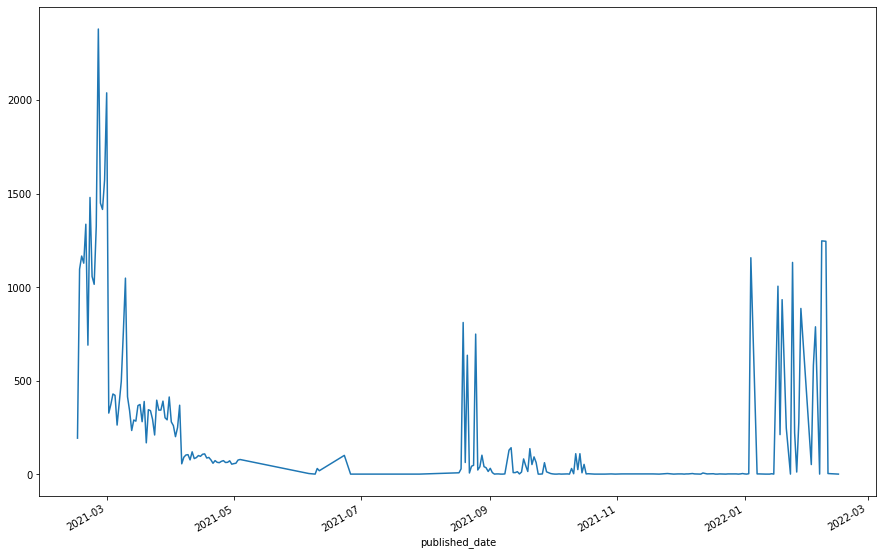

In [268]:
df_date.plot(figsize=(15,10))

In [9]:
df_cols = ['event_type', 'fragment', 'document_title', 'document_authors']  # the rest are noise for featurization

In [10]:
df[df_cols] = df[df_cols].astype(str)

In [165]:
process = False

if process:
    g2 = g.nodes(df, 'n').featurize(use_columns=df_cols)
    # now save the features so we don't have to reprocess 
    X = g2.node_features
    dump(X, 'data/darkweb_features.pickle')
else:
    X = load('data/darkweb_features.pickle')
    g2 = g.nodes(df, 'n')
    g2.node_features = X

In [166]:
g3 = g2.umap(scale=.5, n_neighbors=7)

[feature_utils.py:1046 -                 umap() ] There are repeat entities in node table, we will not relabel nodes
[feature_utils.py:921 - _featurize_or_get_nodes_data_if_X_is_None() ] Found Node features in `res`
[umap_utils.py:92 -                  fit() ] Starting UMAP-ing data of shape (48519, 815)
[umap_utils.py:105 -      _edge_influence() ] Calculating weighted adjacency (edge) DataFrame
[umap_utils.py:96 -                  fit() ] -UMAP-ing took 0.80 minutes total
[umap_utils.py:97 -                  fit() ]  - or 60811.42 rows per minute
[feature_utils.py:776 - prune_weighted_edges_df() ] edge weights: mean( 0.69), std( 0.35)
[feature_utils.py:779 - prune_weighted_edges_df() ] Pruning weighted edge DataFrame from 411554 to 213610 edges


In [15]:
g3.nodes(df[df_cols+['n']], 'n').plot() # what a mess, but nice clusters

# Let's cluster and see how well dimensional reduction has done to group similar records

In [167]:
emb = g3.node_embedding

In [189]:
clustering = DBSCAN(eps=3, min_samples=2).fit(emb)
labels = clustering.labels_
cnt = Counter(labels).most_common()
cnt

[(388, 3601),
 (2, 2372),
 (173, 1850),
 (295, 1462),
 (482, 1339),
 (473, 1097),
 (487, 993),
 (491, 786),
 (13, 681),
 (374, 638),
 (405, 615),
 (387, 590),
 (383, 581),
 (372, 578),
 (488, 573),
 (377, 530),
 (376, 525),
 (486, 515),
 (375, 509),
 (307, 494),
 (391, 493),
 (490, 476),
 (301, 463),
 (305, 456),
 (381, 389),
 (309, 381),
 (382, 369),
 (373, 367),
 (92, 363),
 (394, 358),
 (220, 356),
 (384, 355),
 (414, 345),
 (489, 342),
 (509, 337),
 (528, 337),
 (310, 323),
 (379, 318),
 (380, 313),
 (390, 304),
 (510, 296),
 (529, 295),
 (308, 292),
 (304, 290),
 (294, 285),
 (386, 264),
 (25, 260),
 (494, 260),
 (312, 247),
 (19, 232),
 (33, 232),
 (396, 220),
 (397, 219),
 (455, 217),
 (46, 216),
 (192, 209),
 (54, 205),
 (395, 203),
 (526, 198),
 (378, 197),
 (511, 197),
 (3, 196),
 (175, 191),
 (315, 191),
 (317, 180),
 (483, 178),
 (484, 168),
 (22, 167),
 (148, 165),
 (52, 164),
 (306, 164),
 (537, 158),
 (533, 155),
 (16, 154),
 (322, 152),
 (18, 146),
 (313, 146),
 (302, 1

In [190]:
len(cnt) # lots of clusters

573

In [191]:
cdf = df[labels==3]  #makes sense
cdf[df_cols]

,event_type,fragment,document_title,document_authors
9,Mention,"this cannabis strain, it is no surprise Runtz ...",*SALE* 448g Pound Runtz Cali Indoor Bud,[officialstatus (1)]
49,Mention,Vendor: | [officialstatus,*SALE* 3.5g 1/8th Ounce Guavalato Cali Indoor Bud,[officialstatus (1)]
74,Mention,your order wework diligently to process orders...,*SALE* 7g Quarter Ounce Guavalato Cali Indoor Bud,[officialstatus (1)]
95,Mention,And we want to show our customers that our can...,*SALE* 14g Half Ounce Oreoz Cali Indoor Bud,[officialstatus (1)]
134,Mention,This is to protect both the,*SALE* 112g QP Guavalato Cali Indoor Bud,[officialstatus (1)]
...,...,...,...,...
9802,Mention,* [ Feedback 0 ](/listing/4acfd1e8-4ef5-4f4e-a...,*SALE* 1 Pound / 448g Oreoz Cali Indoor Bud - ...,[officialstatus (1)]
9856,Mention,negative reviews.or for damage from shipping c...,*SALE* 14g Half Ounce Runtz Cali Indoor Bud,[officialstatus (1)]
9892,Mention,Vendor: | [officialstatus,*SALE* 1 Ounce / 28g Oreoz Cali Indoor Bud,[officialstatus (1)]
9927,Mention,available.,*SALE* 14g Half Ounce Runtz Cali Indoor Bud,[officialstatus (1)]


In [259]:
cdf.resample('Q').size()

publication_date
2022-03-31    196
Freq: Q-DEC, dtype: int64

# Use SpaCy to see if we can extract some useful info and de-noise

In [35]:
OBJECT_DEPS = {"dobj", "dative", "attr", "oprd"}
SUBJECT_DEPS = {"nsubj", "nsubjpass", "csubj", "agent", "expl"}
# tags that define wether the word is wh-
WH_WORDS = {"WP", "WP$", "WRB"}

# extract the subject, object and verb from the input
def get_svo_lemmas(doc):
    """Get Subject Verb Object Triples"""
    sub = []
    at = []
    ve = []
    for token in doc:
        # is this a verb?
        if token.pos_ == "VERB":
            ve.append(token.lemma_)
        # is this the object?
        if token.dep_ in OBJECT_DEPS or token.head.dep_ in OBJECT_DEPS:
            at.append(token.lemma_)
        # is this the subject?
        if token.dep_ in SUBJECT_DEPS or token.head.dep_ in SUBJECT_DEPS:
            sub.append(token.lemma_)
    return [k for k in zip(sub, ve, at)]

def extract_named_ents(text):
    """Extract named entities
    """
    return [(ent.text, ent.label_) for ent in nlp(text).ents]


In [328]:
doc = df.fragment.sample(1).values[0]
doc = nlp(doc)
get_svo_lemmas(doc) #meh

[('etsy.com', 'attach', '-')]

In [329]:
extract_named_ents(doc)

[('30 14244', 'CARDINAL'),
 ('0', 'CARDINAL'),
 ('10.00', 'CARDINAL'),
 ('24.06.2020', 'CARDINAL'),
 ('2.0', 'CARDINAL')]

In [72]:
good_cols = ['n', 'fragment', 'document_title', 'document_authors', 'event_type', 'document_id']
good_cols2 = ['n', 'fragment', 'document_title']

In [208]:
#ents = df.fragment.apply(lambda x: extract_named_ents(nlp(str(x))))

In [205]:
#ents.values 

array([list([]),
       list([('IP', 'ORG'), ('223.204.231.232UserName', 'CARDINAL'), ('21110Location', 'CARDINAL'), ('188CAE0C4848663F0653095C9E5A9BB5Current', 'CARDINAL'), ('English', 'LANGUAGE'), ('United', 'ORG'), ('1366x768TimeZone', 'CARDINAL'), ('UTC+07:00', 'NORP'), ('Bangkok', 'GPE'), ('Hanoi', 'GPE'), ('JakartaOperation System', 'ORG'), ('KeyboardLayouts', 'PRODUCT'), ('English', 'LANGUAGE'), ('Core(TM', 'GPE'), ('2', 'CARDINAL'), ('CoresName', 'PRODUCT'), ('2210398208', 'DATE'), ('RAM', 'ORG'), ('8084.31', 'CARDINAL'), ('8477011968', 'DATE'), ('Avira', 'PERSON'), ('Mozilla/5.0 (Windows NT 6.1', 'WORK_OF_ART'), ('Win64', 'ORG'), ('x64', 'ORG'), ('AppleWebKit/537.36', 'ORG'), ('KHTML', 'ORG'), ('Gecko', 'ORG')]),
       list([('https://www.amil.com.br/portal/web/servicos/funcionalidade/acesso-', 'ORG')]),
       list([('https://id.orange.fr https://wwwd.caf.fr', 'PERSON')]),
       list([('https://wwwd.caf.fr/wps/portal/caffr/login/!ut/p/c5/04_SB8K8xLLM9MSSzPy8xBz9CP0os_gAf0N3

In [211]:
#nents = [(k, v) for k, v in enumerate(ents.values) if v != list([])]

In [212]:
#nents

[(8, [('Hindu Kush', 'PERSON')]),
 (9, [('Runtz', 'ORG'), ('Leafly Strain', 'PERSON')]),
 (10, [('Hindu Kush', 'PERSON')]),
 (13, [('#####', 'MONEY')]),
 (20, [('#####', 'MONEY')]),
 (21, [('50)](/profile/view/952d547c-de6f-486a-884d-df8aa131067f', 'ORG')]),
 (22, [('28%', 'PERCENT')]),
 (24, [('the new year', 'DATE')]),
 (25, [('114.55', 'CARDINAL'), ('USD', 'ORG')]),
 (28, [('50.00', 'CARDINAL')]),
 (30, [('28', 'CARDINAL'), ('Strawberry', 'PERSON')]),
 (32, [('first', 'ORDINAL')]),
 (36, [('Negative', 'ORG')]),
 (37, [('the United States', 'GPE')]),
 (41, [('Fireline', 'PERSON')]),
 (42, [('Hindu Kush', 'PERSON')]),
 (45, [('first', 'ORDINAL')]),
 (46, [('Digital', 'ORG')]),
 (47, [('Kush', 'WORK_OF_ART')]),
 (50, [('Credit Card', 'ORG')]),
 (55, [('126)](/profile', 'CARDINAL')]),
 (56, [('Crystal Meth', 'LOC')]),
 (57, [('One', 'CARDINAL')]),
 (61, [('File Size', 'PERSON'), ('130', 'CARDINAL'), ('GB', 'ORG')]),
 (64, [('1', 'CARDINAL')]),
 (69, [('100%', 'PERCENT')]),
 (71, [('Supe

In [ ]:
# Let's analyze using ngram analysis

In [331]:
doclength = df.document_title.apply(lambda x: len(x.split()))

In [332]:
df['title_length'] = doclength

<AxesSubplot:ylabel='Frequency'>

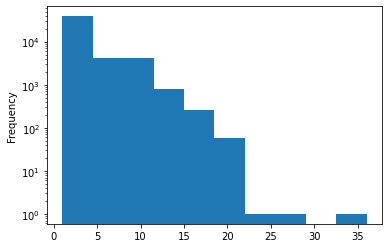

In [54]:
doclength.plot(kind='hist', log=True)

In [333]:
df['fragment_length'] = df.fragment.apply(lambda x: len(str(x).split()))

<AxesSubplot:>

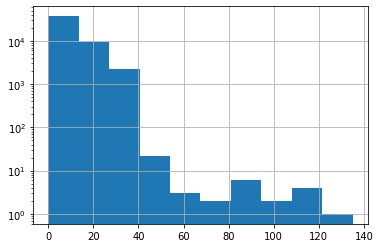

In [334]:
df.fragment_length.hist(log=True)

# Let's prune to documents that have minimum length 
## Smaller sample for prototyping

In [335]:
bdf = df[(df.fragment_length>5) & (df.title_length>5)]

In [336]:
bdf['n'] = range(len(bdf))

# let's find a word to word score
## This will be useful to find, quickly, what sellers are involved in over all the data

In [623]:
import csv
# wget https://www.sketchengine.eu/english-word-list/
reader = csv.reader(open('data/english-word-list-total.csv', 'r'))
data = [row for row in reader]
remove_words = [data[k][0].split(';')[1] for k in range(len(data))]
remove_words = remove_words[1:]

In [415]:
# let's encode as ngrams with usernames too
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(min_df=3, max_df=0.35, ngram_range=(1,3), stop_words=remove_words)

# make the matrix with seller included
M = np.array(cvect.fit_transform(
    bdf.fragment.astype(str).values + 
    ' ' + bdf.document_title.astype(str).values +
    ' ' + bdf.document_authors.values).todense())

top_sims = 10
coldict = {k:v for v, k in cvect.vocabulary_.items()}
ww = np.cov(M.T)
w2w = [[coldict[k] for k in row.argsort()[::-1][:top_sims]] for row in ww]

In [338]:
def word_in_key(word, wdict):
    indices = []
    wordlist = []
    for w, indx in wdict.items():
        if word in w:
            indices.append(indx)
            wordlist.append(w)
    return wordlist, indices


def get_top_correlated_words(word, verbose=False):
    wordlist, indices = word_in_key(word.lower(), cvect.vocabulary_)
    seen = set()
    bests = []
    for w, i in zip(wordlist, indices):
        if w not in seen:
            #print(f'{word}: {w} -> {w2w[i]}')
            bests+= w2w[i]
        else:
            seen.add(w)
    bests = sorted(np.unique(bests))
    print(f'{word} -> {bests}') if verbose else None
    return bests

def get_random_word():
    return np.random.choice(list(cvect.vocabulary_))
    

In [365]:
# If we want to see how well entities correlate via ngrams -- not as good as g3.umap().plot()
# cc = np.cov(M)
# rows, cols = cc.nonzero()
# edges = pd.DataFrame({'a': rows, 'b':cols, 'weight': cc[rows, cols]})
# edges_pruned = prune_weighted_edges_df(edges, scale=8)
# g = graphistry.nodes(bdf, 'n').edges(edges_pruned, 'a', 'b')
# g.plot()

In [340]:
# user 'word cloud' 
r=get_top_correlated_words('DopeValley', verbose=True)

DopeValley -> ['1g crystal', 'aaa', 'aaa dopevalley', 'aaa molly', 'aaa molly dopevalley', 'cocaine', 'cocaine aaa', 'cocaine aaa dopevalley', 'crystal', 'crystal meth', 'crystal meth aaa', 'dopevalley', 'mdma', 'mdma aaa', 'mdma aaa molly', 'meth', 'meth aaa', 'meth aaa dopevalley', 'molly', 'molly dopevalley', 'ninja', 'ninja ne', 'ninja ne eastwood', 'ninjas', 'refunds reships provided']


In [310]:
def get_likely_drugs_or_region(username):
    r=get_top_correlated_words(username)
    drugs = Counter()
    for a in r:
        res = extract_named_ents(nlp(str(a)))
        if len(res):
            for k in res:
                if len(k)==2:
                    aa, b = k
                    if b in ['GPE', 'ORG', 'NP', 'PERSON']:
                        res = aa.split()[0]
                        if res.lower() != username.lower():
                            drugs.update([res])
    if len(drugs):
        print(f'{username} is likely selling (item/drug/region) -- ')
        print('-'*30)
        for n, c in drugs.most_common():
            print(f'\t{n.upper()}  ->  score {c/len(drugs):.2f}')
        print()
    return drugs

c=get_likely_drugs_or_region('DopeValley')

DopeValley is likely selling (item/drug/region) -- 
------------------------------
	AAA  ->  score 1.25
	METH  ->  score 1.00
	MDMA  ->  score 0.75
	COCAINE  ->  score 0.25



In [342]:
bdf['seller'] = bdf.document_authors.apply(lambda x: x.split()[0].replace('[', '').replace(']', ''))

In [343]:
bdf.groupby('seller').agg('mean')

,n,title_length,fragment_length
seller,,,
AmphetamineCowboys,181.500000,6.000000,6.000000
Ausbest,181.000000,9.000000,35.000000
AvbeaAU,2908.500000,6.425000,10.841667
BOKATINEBIGV123,177.000000,11.500000,8.000000
Bossking003,21.500000,8.000000,10.000000
...,...,...,...
topkittzz,156.888889,9.000000,35.000000
trusteelucky,191.000000,14.600000,8.600000
wfowfo,1167.007968,11.039841,10.378486


In [346]:
# instead of username, put in anything...
r=get_likely_drugs_or_region('cocaine')

cocaine is likely selling (item/drug/region) -- 
------------------------------
	BOLIVIAN  ->  score 0.67
	UNCUT92  ->  score 0.56
	AAA  ->  score 0.33
	AMATEUR  ->  score 0.22
	MDMA  ->  score 0.22
	FISHSCALE  ->  score 0.22
	PERU  ->  score 0.22
	UK  ->  score 0.11
	DOPEVALLEY  ->  score 0.11



In [356]:
# get all sellers and see what they might be selling
users = Counter(bdf.seller).most_common()
resses = []
for user, count in users:
    r = get_likely_drugs_or_region(user)
    resses.append(r)

Frulite is likely selling (item/drug/region) -- 
------------------------------
	GSC  ->  score 1.17
	BOLIVIAN  ->  score 0.50
	COOKIES  ->  score 0.50
	GRAMS  ->  score 0.50
	MDMA  ->  score 0.50
	KUSH  ->  score 0.17

wfowfo is likely selling (item/drug/region) -- 
------------------------------
	ECKMARS  ->  score 0.50
	MARKETPLACE  ->  score 0.50

SubShop is likely selling (item/drug/region) -- 
------------------------------
	AMEX  ->  score 1.25
	MASTERCARD  ->  score 1.00
	VISA  ->  score 0.50
	ACCOUNT  ->  score 0.25

AvbeaAU is likely selling (item/drug/region) -- 
------------------------------
	METH  ->  score 2.50
	CRYSTAL  ->  score 0.50

officialstatus is likely selling (item/drug/region) -- 
------------------------------
	CALI  ->  score 1.25
	BUBBA  ->  score 0.75
	BUD  ->  score 0.25
	KUSH  ->  score 0.25

fraudbuddy is likely selling (item/drug/region) -- 
------------------------------
	BITSTAMP  ->  score 0.33
	COOKIE  ->  score 0.33
	EMAIL  ->  score 0.33

ozzyco 

In [365]:
from sklearn.feature_extraction import DictVectorizer
dvect = DictVectorizer()

dm = np.array(dvect.fit_transform(resses).todense())

In [366]:
dm  # users x NER tags

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [370]:
doldict = {k:v for v, k in dvect.vocabulary_.items()}

In [374]:
indices = dm.sum(0).argsort()[::-1]
drug_cols = [doldict[k] for k in indices]

Users by top (items/drugs/locations)


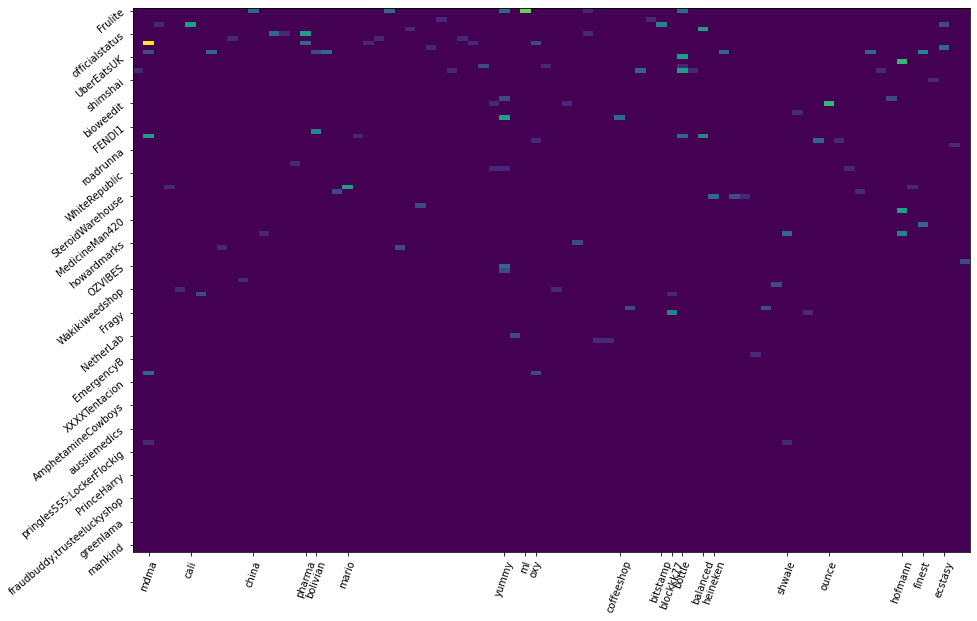

In [392]:
plt.figure(figsize=(15,10))
plt.imshow(dm, aspect='auto')

topN = 20
plt.xticks(indices[:topN], np.array(drug_cols)[indices[:topN]], rotation=70)


plt.yticks(np.arange(0, len(dm), 5), np.array([u for u, c in users])[::5], rotation=40)
print('Users by top (items/drugs/locations)')

Abundance over time


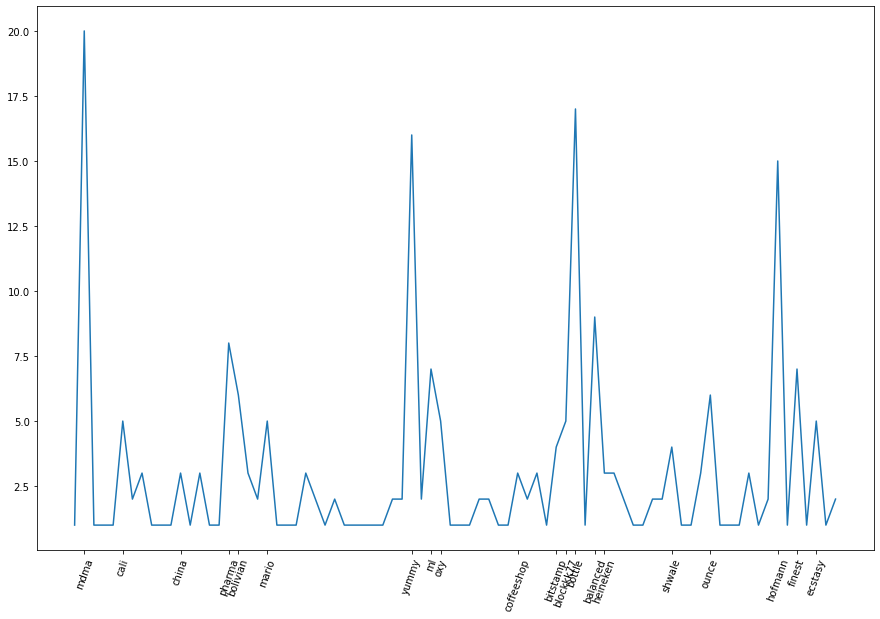

In [399]:
plt.figure(figsize=(15,10))
plt.plot(dm.sum(0))
topN = 20
plt.xticks(indices[:topN], np.array(drug_cols)[indices[:topN]], rotation=70)

print('Abundance over time')

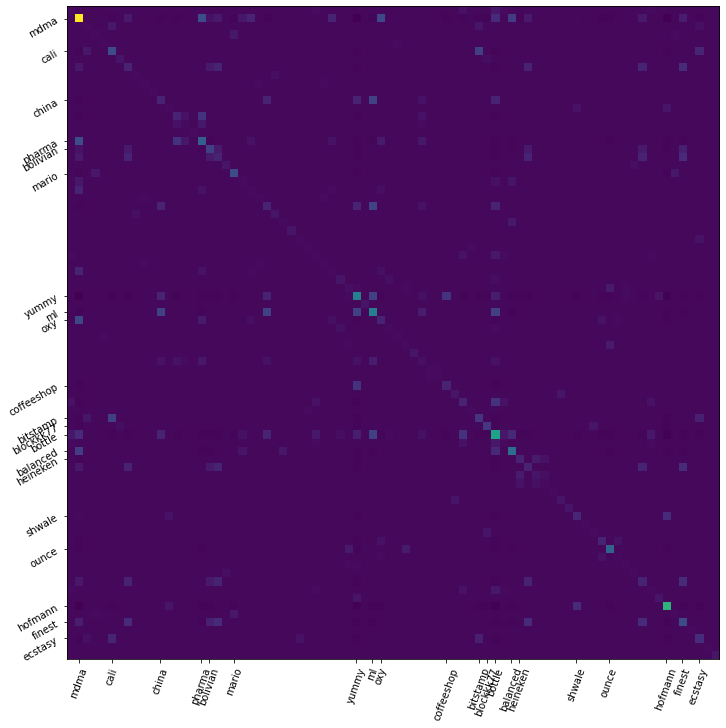

In [629]:
plt.figure(figsize=(12,12))
plt.imshow(np.cov(dm.T))
plt.xticks(indices[:topN], np.array(drug_cols)[indices[:topN]], rotation=70)
plt.yticks(indices[:topN], np.array(drug_cols)[indices[:topN]], rotation=30)
print()

In [632]:
cc = np.cov(dm.T)
sims = [[doldict[k] for k in row.argsort()[::-1][1:5]] for row in cc]
sims

[['mario', '4mmc', 'ecstasy', 'mephedrone'],
 ['cali', 'haze', 'meth', 'mdma'],
 ['mastercard', 'visa', 'account', 'blockkk77'],
 ['adderall', 'uncut', 'marketplace', 'crystal'],
 ['hofmann', 'account', 'crystal', 'eckmars'],
 ['mastercard', 'visa', 'account', 'eckmars'],
 ['max', 'account', 'crystal', 'eckmars'],
 ['australia', 'michigan', 'spain', 'canada'],
 ['balanced', 'account', 'crystal', 'eckmars'],
 ['cookie', 'bitstamp', 'nouveaux', 'cocaine'],
 ['account', 'crystal', 'eckmars', 'marketplace'],
 ['cookies', 'bolivian', 'grams', 'mdma'],
 ['pharma', 'bottle', 'account', 'crystal'],
 ['bubba', 'bud', 'kush', 'heineken'],
 ['bubba', 'bud', 'kush', 'shwale'],
 ['account', 'crystal', 'eckmars', 'marketplace'],
 ['aaa', 'bubba', 'haze', 'bud'],
 ['usa', 'michigan', 'australia', 'spain'],
 ['australia', 'michigan', 'spain', 'canada'],
 ['south', 'account', 'crystal', 'eckmars'],
 ['adderall', 'uncut', 'south', 'sativa'],
 ['meth', 'mdma', 'cocaine', 'crystal'],
 ['cali', 'haze', 'co

In [ ]:
# some examples

In [561]:
sims = get_top_correlated_words(get_random_word(), verbose=True)

blacked dogfartnetwork amateur -> ['amateur', 'amateur cocaine', 'amateur cocaine mdma', 'blacked', 'blacked dogfartnetwork', 'blacked dogfartnetwork amateur', 'cocaine mdma', 'dogfartnetwork', 'dogfartnetwork amateur', 'dogfartnetwork amateur cocaine']


In [313]:
sims = get_top_correlated_words(get_random_word(), verbose=True)

noumena dmt ozvibes -> ['dmt', 'ketamine pure clean', 'noumena', 'noumena dmt', 'noumena dmt ozvibes', 'psycheshop', 'psycheshop lsd ketamine']


In [558]:
sims = get_top_correlated_words(get_random_word(), verbose=True)

clonidine 30 -> ['100mcg sale withdrawals', 'clonidine', 'opiate', 'opiate user', 'sale withdrawals', 'sale withdrawals opiate', 'tablets 100mcg', 'user pablitosbodega', 'withdrawals opiate', 'withdrawals opiate user']


# Now let's see words per seller (time ordered) [Not Interesting]

In [348]:
groups = [bdf[bdf.seller==user] for user, c in users]

In [403]:
groups[1].fragment

41820    PLEASE DO NOT ORDER UNLESS YOU UNDERSTAND YOU ...
41822    Metatags: | #weed #cannabis #bud #flowers #imp...
41828    A+ AMNESIA HAZE IMPORT GOOD QUALITY - (1G-56G)...
41833    COLLECTIONS, LATEST IT MAY TAKE UP TO 2-3 DAYS!!!
41840    #vape #wild #apple #ml #10ml #calm #relaxed #s...
                               ...                        
44484    REASON YOUR ARE UNHAPPY WITH AN ORDER PLEASE M...
44512    OUR BEST TO KEEP YOU, AS OUR CUSTOMER, HAPPY A...
44565    PACKAGES WILL ALWAYS BE POSTED BY US WITH FULL...
44575    REASON YOUR ARE UNHAPPY WITH AN ORDER PLEASE M...
44580    #high quality #NDD #sweet #tasty #potent #euph...
Name: fragment, Length: 363, dtype: object

In [404]:
len(groups)

117

In [421]:
mats = []
for i, gdf in enumerate(groups):
    m = np.array(cvect.transform(gdf.fragment.astype(str).values + 
    ' ' + gdf.document_title.astype(str).values +
    ' ' + gdf.document_authors.values).todense())
    mats.append(m)
    print(users[i], m.shape)


('Frulite', 1213) (1213, 6444)
('El-Chapo', 363) (363, 6444)
('wfowfo', 251) (251, 6444)
('SubShop', 132) (132, 6444)
('AvbeaAU', 120) (120, 6444)
('officialstatus', 107) (107, 6444)
('fraudbuddy', 99) (99, 6444)
('ozzyco', 90) (90, 6444)
('perfectways', 80) (80, 6444)
('h3exx', 59) (59, 6444)
('UberEatsUK', 59) (59, 6444)
('lysanderspooner', 53) (53, 6444)
('DHLGermany', 36) (36, 6444)
('amsterdamxpress', 30) (30, 6444)
('FlyHigh', 29) (29, 6444)
('shimshai', 29) (29, 6444)
('LaoTzu', 29) (29, 6444)
('fraudmigo', 28) (28, 6444)
('MARLEYSSHOP', 27) (27, 6444)
('CocaColaCompany', 27) (27, 6444)
('bioweedit', 27) (27, 6444)
('HappyShopOrigi', 27) (27, 6444)
('Mobileman', 22) (22, 6444)
('fungalvibrations', 21) (21, 6444)
('flexowned', 19) (19, 6444)
('FENDI1', 19) (19, 6444)
('EiffelCartel', 19) (19, 6444)
('DopeValley', 18) (18, 6444)
('California420Service', 18) (18, 6444)
('Kushx23', 17) (17, 6444)
('roadrunna', 17) (17, 6444)
('yqnickroll', 16) (16, 6444)
('MASTERSS5', 16) (16, 6444)

In [417]:
[coldict[k] for k in mats[0].sum(0).argsort()[::-1][:topN]] # better using 

['frulite',
 'premium',
 'kush',
 'hindu',
 'hindu kush',
 'ez',
 'tested',
 'thc',
 'kush premium',
 'hindu kush premium',
 'cocaine',
 'premium thc',
 'kush premium thc',
 '20',
 'thc 20',
 'premium thc 20',
 '10',
 'test',
 'purity',
 'bolivian']

In [420]:
[coldict[k] for k in mats[1].sum(0).argsort()[::-1][:topN]]

['ndd',
 'uk',
 'ndd uk',
 'chapo',
 'el',
 'el chapo',
 'uk el',
 'ndd uk el',
 'uk el chapo',
 'aaa',
 'import',
 'thc',
 'patch',
 'import ndd uk',
 'import ndd',
 'haze',
 'haze import',
 'haze import ndd',
 'sour',
 'sour patch']

In [97]:
sims = get_top_correlated_words(get_random_word())

28g hyaline meth -> ['28g hyaline', '28g hyaline meth', 'hyaline meth ice', 'meth', 'meth 28g', 'meth 28g hyaline', 'meth ice avbeaau']


# Featurize and cluster in bdf

In [74]:
good_cols3 = ['fragment', 'document_title', 'document_authors']

In [75]:
g2 = graphistry.nodes(bdf, 'n').featurize(use_columns=good_cols3)

[feature_utils.py:164 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `n` so we do not featurize it
[feature_utils.py:803 - get_dataframe_columns() ] returning DataFrame with columns `['fragment', 'document_title', 'document_authors']`
[feature_utils.py:434 - check_if_textual_column() ] 
	Column `fragment` looks textual with mean number of words 10.41
[feature_utils.py:434 - check_if_textual_column() ] 
	Column `document_title` looks textual with mean number of words 9.10
[feature_utils.py:484 -       encode_textual() ] -Calculating Embeddings for column `fragment`
[feature_utils.py:484 -       encode_textual() ] -Calculating Embeddings for column `document_title`
[feature_utils.py:487 -       encode_textual() ] Encoded Textual data at 1574.45 rows per column minute
[feature_utils.py:611 - process_dirty_dataframes() ] Encoding DataFrame might take a few minutes --------
[feature_utils.py:616 - process_dirty_dataframes() ] -Shape of data (3473, 42)

[featu

In [79]:
g3 = g2.umap(scale=1, n_neighbors=7)

[feature_utils.py:1046 -                 umap() ] There are repeat entities in node table, we will not relabel nodes
[feature_utils.py:921 - _featurize_or_get_nodes_data_if_X_is_None() ] Found Node features in `res`
[feature_utils.py:933 - _featurize_or_get_nodes_data_if_X_is_None() ] Fetching `node_target` in `res`. Target is type <class 'NoneType'>
[umap_utils.py:92 -                  fit() ] Starting UMAP-ing data of shape (3473, 810)
/Users/alexmorisse/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
[umap_utils.py:105 -      _edge_influence() ] Calculating weighted adjacency (edge) DataFrame
[umap_utils.py:96 -                  fit() ] -UMAP-ing took 0.29 minutes total
[umap_utils.py:97 -                  fit() ]  - or 12039.12 rows per minute
[feature_utils.py:776 - prune_weighted_edges_d

In [80]:
g3.plot()

In [424]:
bdf['time'] = pd.to_datetime(bdf['published_date'])

<AxesSubplot:xlabel='time'>

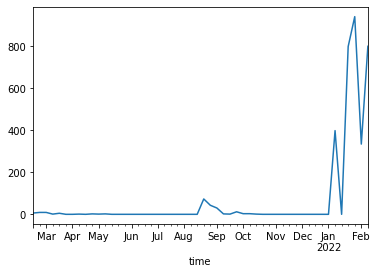

In [426]:
bdf.resample('W', on='time')['seller'].count().plot() #boo

# Lets do multi source correlation

In [434]:
dro = pd.read_csv('~/Downloads/Drug Related Offenses 2.csv')

In [436]:
dro.groupby('Offense Type').count()

,Incident Date,Number of Crimes
Offense Type,,
Aggravated Assault,7306,2151
Animal Cruelty,7306,8
Arson,7306,36
Bribery,7306,14
Burglary,7306,2548
Commercial Sex Acts,7306,11
Counterfeiting/Forgery,7306,3225
Destruction/Damage/Vandalism,7306,1517
Drug/Narcotic Equipment Violations,7306,6049


In [438]:
dro = dro.fillna(0)

In [478]:
narco = dro[dro['Offense Type'] == 'Drug/Narcotic Violations'][1:]

In [479]:
narco

,Offense Type,Incident Date,Number of Crimes
306853,Drug/Narcotic Violations,"Dec 31, 2020",131
306854,Drug/Narcotic Violations,"Dec 30, 2020",132
306855,Drug/Narcotic Violations,"Dec 29, 2020",129
306856,Drug/Narcotic Violations,"Dec 28, 2020",94
306857,Drug/Narcotic Violations,"Dec 27, 2020",70
...,...,...,...
314153,Drug/Narcotic Violations,"Jan 5, 2001",0
314154,Drug/Narcotic Violations,"Jan 4, 2001",1
314155,Drug/Narcotic Violations,"Jan 3, 2001",1
314156,Drug/Narcotic Violations,"Jan 2, 2001",0


In [482]:
narco['date'] = pd.to_datetime(narco['Incident Date'], errors='coerce')
narco = narco.sort_values(by='date', ascending=True, ignore_index=True)
narco['Number of Crimes'] = narco['Number of Crimes'].astype(int)
#narco.set_index('date', inplace=True)

<AxesSubplot:xlabel='date'>

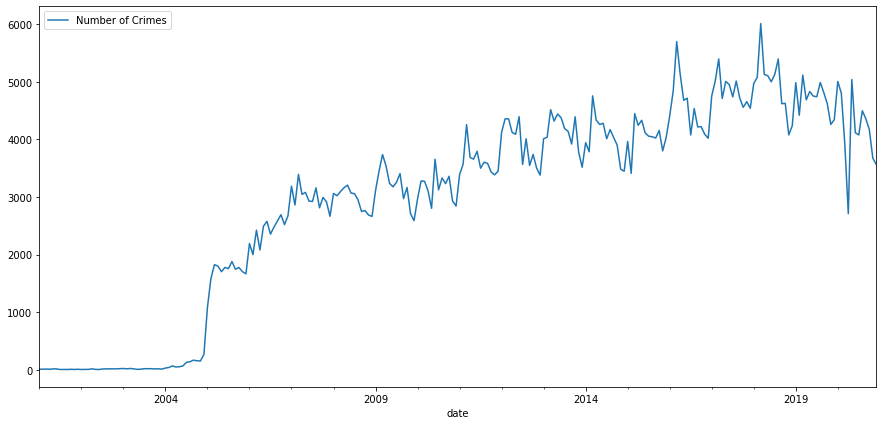

In [509]:
narco.resample('M', on='date').sum().plot(figsize=(15,7))

In [592]:
odf = pd.read_csv('~/Downloads/Opioid Report.csv') #skiprows

In [593]:
odf = odf[1:]
odf = odf.fillna(0)

In [594]:
odf['Number of Drug Reports']=odf['Number of Drug Reports'].apply(lambda x: 0 if ',' in str(x) else int(x))

In [595]:
odf['date'] = pd.to_datetime(odf['Incident Date'], errors='coerce')
odf = odf.sort_values(by='date', ascending=True, ignore_index=True)
odf['Number of Drug Reports'] = odf['Number of Drug Reports'].astype(int)
odf = odf[:-5]

<AxesSubplot:xlabel='date'>

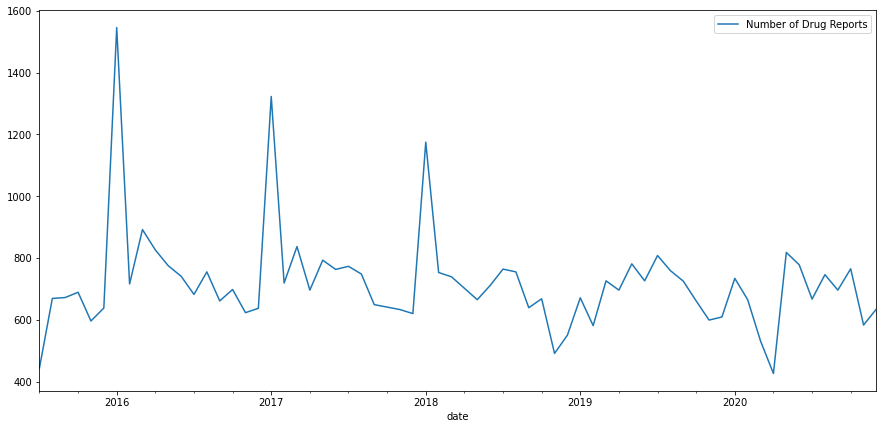

In [597]:
odf.resample('M', on='date').sum().plot(figsize=(15,7))

In [596]:
odf

,Drug Type,Incident Date,Number of Drug Reports,date
0,Other Narcotics,"Jul 12, 2015",11,2015-07-12
1,Morphine,"Jul 12, 2015",1,2015-07-12
2,Carfentanil,"Jul 12, 2015",0,2015-07-12
3,Fentanyl,"Jul 12, 2015",0,2015-07-12
4,Heroin,"Jul 12, 2015",0,2015-07-12
...,...,...,...,...
12010,Opium,"Dec 31, 2020",0,2020-12-31
12011,Heroin,"Dec 31, 2020",20,2020-12-31
12012,Morphine,"Dec 31, 2020",1,2020-12-31
12013,Carfentanil,"Dec 31, 2020",0,2020-12-31


In [566]:
hdf = pd.read_csv('~/Downloads/Heroin & Fentanyl.csv', skiprows=30, names='date place drug counts'.split())

In [567]:
hdf.head()

,date,place,drug,counts
0,"Dec 31, 2020",Tennessee,Fentanyl,2.0
1,"Dec 31, 2020",Tennessee,Carfentanil,NaN
2,"Dec 31, 2020",Tennessee,Heroin,25.0
3,"Dec 30, 2020",Tennessee,Fentanyl,NaN
4,"Dec 30, 2020",Tennessee,Carfentanil,NaN


In [569]:
hdf['counts'] = hdf['counts'].fillna(0)

In [570]:
hdf['date'] = pd.to_datetime(hdf['date'], errors='coerce')
hdf = hdf.sort_values(by='date', ascending=True, ignore_index=True)
hdf['counts'] = hdf['counts'].astype(int)

In [571]:
drug_counts = hdf.groupby('drug').resample('W', on='date').sum()

<AxesSubplot:xlabel='date'>

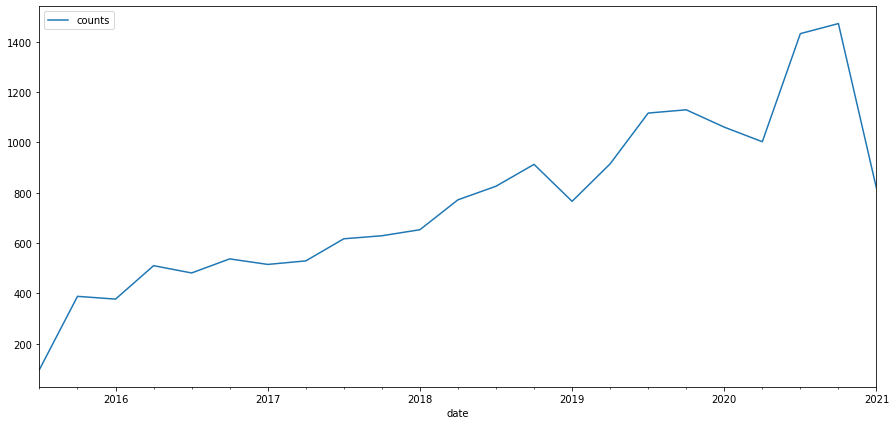

In [572]:
hdf.resample('3M', on='date').sum().plot(figsize=(15,7))

In [617]:
hhdf = hdf[hdf.drug=='Heroin']

In [598]:
odf.date.min(), hdf.date.min(), 

(Timestamp('2015-07-12 00:00:00'), Timestamp('2015-07-12 00:00:00'))

In [599]:
odf.date.max(), hdf.date.max()

(Timestamp('2020-12-31 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [602]:
odf.groupby('Drug Type').sum()

,Number of Drug Reports
Drug Type,
Carfentanil,4
Fentanyl,789
Heroin,12709
Morphine,2955
Opium,2060
Other Narcotics,28936


In [604]:
hodf = odf[odf['Drug Type'] == 'Heroin']

In [611]:
hodf

,Drug Type,Incident Date,Number of Drug Reports,date
4,Heroin,"Jul 12, 2015",0,2015-07-12
10,Heroin,"Jul 13, 2015",3,2015-07-13
14,Heroin,"Jul 14, 2015",8,2015-07-14
21,Heroin,"Jul 15, 2015",5,2015-07-15
29,Heroin,"Jul 16, 2015",5,2015-07-16
...,...,...,...,...
11988,Heroin,"Dec 27, 2020",8,2020-12-27
11994,Heroin,"Dec 28, 2020",5,2020-12-28
12001,Heroin,"Dec 29, 2020",11,2020-12-29
12005,Heroin,"Dec 30, 2020",11,2020-12-30


In [618]:
len(hodf), len(hhdf)

(2003, 2000)

In [619]:
res = pd.merge_asof(hodf, hhdf, on='date') #cool function
res

,Drug Type,Incident Date,Number of Drug Reports,date,place,drug,counts
0,Heroin,"Jul 12, 2015",0,2015-07-12,Tennessee,Heroin,0
1,Heroin,"Jul 13, 2015",3,2015-07-13,Tennessee,Heroin,4
2,Heroin,"Jul 14, 2015",8,2015-07-14,Tennessee,Heroin,11
3,Heroin,"Jul 15, 2015",5,2015-07-15,Tennessee,Heroin,9
4,Heroin,"Jul 16, 2015",5,2015-07-16,Tennessee,Heroin,5
...,...,...,...,...,...,...,...
1998,Heroin,"Dec 27, 2020",8,2020-12-27,Tennessee,Heroin,9
1999,Heroin,"Dec 28, 2020",5,2020-12-28,Tennessee,Heroin,7
2000,Heroin,"Dec 29, 2020",11,2020-12-29,Tennessee,Heroin,15
2001,Heroin,"Dec 30, 2020",11,2020-12-30,Tennessee,Heroin,17


In [620]:
from scipy import stats

stats.pearsonr(res['Number of Drug Reports'], res.counts)

(0.9391147907149754, 0.0)

In [621]:
np.corrcoef(res['Number of Drug Reports'], res.counts)

array([[1.        , 0.93911479],
       [0.93911479, 1.        ]])

In [ ]:
# so the heroin - heroin cor is high between the two datasets

# Get news 

In [221]:
import datanews
from dateutil import parser
from pprint import pprint

def parse_datestring(datestring):
    # turns '2021-08-24T21:26:08+00:00' into 'Tue Aug 24 21:26:08 2021'
    return parser.parse(datestring)

def get_unique_hits(docs):
    untitles = set([k["title"] for k in docs])
    ndocs = []
    for k in docs:
        if k["title"] in untitles:
            ndocs.append(k)
            untitles.remove(k["title"])
    return ndocs

def get_news(query, from_date=None, to_date=None, source=None, language="en"):
    # from_date='2021-11-11'
    datanews.api_key = "0lhxl30stv3dfd0jo8yz1pghm"
    response = datanews.news(
        q=query,
        from_date=from_date,
        to_date=to_date,
        language=language,
        source=source,
        size=100,
    )
    if 'hits' in response:
        articles = response["hits"]
        pprint(Counter([row["title"] for row in articles]).most_common(10))
        for k in articles:
            k["pubDate"] = parse_datestring(k["pubDate"])
        return get_unique_hits(articles)
    return None


In [223]:
data = []
for query in ['opiod overdose in tennessee', 'opiod deaths in tennessee', \
              'heroine deaths in tennessee', 'heroine overdoses in tennessee', \
             'illegal drugs in tennessee', 'drug busts in tennessee', 'drug rings in tennessee']:
    articles = get_news(query, from_date='2021-01-01', to_date='2022-02-16')
    data.append([query, articles])

dict_keys(['status', 'numResults', 'hits'])
{'status': 200, 'numResults': 32168361, 'hits': [{'url': 'https://www.sfgate.com/news/bayarea/article/Police-Officer-Administers-Naloxone-During-16125853.php', 'source': 'sfgate.com', 'authors': ['Bay City News Service'], 'title': 'Police Officer Administers Naloxone During Suspected Opiod Overdose', 'pubDate': '2021-04-24T13:02:55+00:00', 'country': 'us', 'language': 'en', 'description': 'Police Officer Administers Naloxone During Suspected Opiod Overdose  SFGate', 'imageUrl': 'https://www.sfgate.com/img/pages/article/opengraph_default.png', 'content': 'A police officer in Emeryville on Friday administered Naloxone to an unresponsive man during a suspected opioid overdose.\n\nOn Friday at 6:29 p.m., officers with the Emeryville Police Department were dispatched to 3889 San Pablo Ave. on a report of an ... [+775 chars]'}, {'url': 'https://tennesseelookout.com/2021/09/13/opioid-overdose-deaths-jump-in-2020/', 'source': 'tennesseelookout.com', 

dict_keys(['status', 'numResults', 'hits'])
{'status': 200, 'numResults': 32183073, 'hits': [{'url': 'https://www.msn.com/en-us/news/us/coronavirus-in-tennessee-tennessee-reports-640-new-cases-three-new-deaths/ar-BB1fz80m', 'source': 'msn.com', 'authors': ['Staff reports'], 'title': 'Coronavirus in Tennessee: Tennessee reports 640 new cases, three new deaths', 'pubDate': '2021-04-13T13:00:48+00:00', 'country': 'us', 'language': 'en', 'description': 'Coronavirus in Tennessee: Tennessee reports 640 new cases, three new deaths  msnNOW', 'imageUrl': 'https://img-s-msn-com.akamaized.net/tenant/amp/entityid/BB1fz5QR.img?h=630&w=1200&m=6&q=60&o=t&l=f&f=jpg', 'content': "We'll have the latest news on the fight against the coronavirus in Tennessee below — as always, for free, because we want to share this vital information with our community. To support our mission, please consider subscribing.\n\nTHIS WEEK IN CORONAVIR ... [+7196 chars]"}, {'url': 'https://tennesseelookout.com/2021/09/13/opioi

dict_keys(['status', 'numResults', 'hits'])
{'status': 200, 'numResults': 32183216, 'hits': [{'url': 'https://www.msn.com/en-us/news/us/coronavirus-in-tennessee-tennessee-reports-640-new-cases-three-new-deaths/ar-BB1fz80m', 'source': 'msn.com', 'authors': ['Staff reports'], 'title': 'Coronavirus in Tennessee: Tennessee reports 640 new cases, three new deaths', 'pubDate': '2021-04-13T13:00:48+00:00', 'country': 'us', 'language': 'en', 'description': 'Coronavirus in Tennessee: Tennessee reports 640 new cases, three new deaths  msnNOW', 'imageUrl': 'https://img-s-msn-com.akamaized.net/tenant/amp/entityid/BB1fz5QR.img?h=630&w=1200&m=6&q=60&o=t&l=f&f=jpg', 'content': "We'll have the latest news on the fight against the coronavirus in Tennessee below — as always, for free, because we want to share this vital information with our community. To support our mission, please consider subscribing.\n\nTHIS WEEK IN CORONAVIR ... [+7196 chars]"}, {'url': 'https://tennesseelookout.com/2021/09/13/opioi

dict_keys(['status', 'numResults', 'hits'])
{'status': 200, 'numResults': 32168007, 'hits': [{'url': 'https://wydaily.com/story/2021/11/10/york-county-man-sentenced-for-distributing-heroine-to-women-who-died-from-overdoses/', 'source': 'wydaily.com', 'authors': ['', 'Ben Mackin'], 'title': 'York County Man Sentenced for Distributing Heroine to Women Who Died from Overdoses', 'pubDate': '2021-11-10T11:59:00+00:00', 'country': '', 'language': 'en', 'description': 'York County Man Sentenced for Distributing Heroine to Women Who Died from Overdoses  WYDaily', 'imageUrl': 'https://d2unfigtnsklzd.cloudfront.net/wp-content/uploads/2017/02/Kerlin.jpg', 'content': 'NEWPORT NEWS — A York County man was sentenced to 17-years in prison by a federal judge for distributing heroine to two women who died from overdoses in his Seaford home among other charges, according to a press release from the U.S. Attorney’s Offic ... [+1071 chars]'}, {'url': 'https://patch.com/tennessee/nashville/fatal-drug-overd

dict_keys(['status', 'numResults', 'hits'])
{'status': 200, 'numResults': 32177348, 'hits': [{'url': 'https://www.timesnews.net/news/crime/bristol-tennessee-man-arrested-for-possession-of-25-000-worth-of-illegal-drugs/article_59bcbf48-7498-11ec-972c-db8cca97b6bb.html', 'source': 'timesnews.net', 'authors': ['From staff reports'], 'title': 'Bristol, Tennessee man arrested for possession of $25000 worth of illegal drugs', 'pubDate': '2022-01-13T18:15:00+00:00', 'country': 'us', 'language': 'en', 'description': 'Bristol, Tennessee man arrested for possession of $25000 worth of illegal drugs  Kingsport Times News', 'imageUrl': 'https://bloximages.newyork1.vip.townnews.com/timesnews.net/content/tncms/assets/v3/editorial/1/04/104d25d0-749a-11ec-bb8c-bf1a68935053/61e067f5a9547.image.jpg?crop=951%2C499%2C4%2C232&resize=951%2C499&order=crop%2Cresize', 'content': "SULLIVAN COUNTY — Sullivan County sheriff's detectives charged a Bristol, Tennessee, man with possession of illegal drugs with a stre

dict_keys(['status', 'numResults', 'hits'])
{'status': 200, 'numResults': 32180780, 'hits': [{'url': 'https://newsinfo.inquirer.net/1438653/7-drug-suspects-in-bulacan-killed-in-separate-busts', 'source': 'newsinfo.inquirer.net', 'authors': ['Philippine Daily Inquirer'], 'title': '7 drug suspects in Bulacan killed in separate busts', 'pubDate': '2021-05-29T11:29:00+00:00', 'country': '', 'language': 'en', 'description': '7 drug suspects in Bulacan killed in separate busts  INQUIRER.net', 'imageUrl': 'https://newsinfo.inquirer.net/files/2021/01/police-line-04jan2021-2-620x310.png', 'content': 'CAMP GEN. ALEJO SANTOS, Bulacan — Seven drug suspects were killed in shootouts with the police during a string of separate operations in 21 towns and three cities that began on the midnight of May 28.\n\nBulacan police director Col. Lawrence Cajipe sai ... [+307 chars]'}, {'url': 'https://www.desiblitz.com/content/5-massive-drug-busts-happened-in-india', 'source': 'desiblitz.com', 'authors': [], 't

dict_keys(['status', 'numResults', 'hits'])
{'status': 200, 'numResults': 32182530, 'hits': [{'url': 'https://www.chron.com/news/article/AG-James-2-drug-rings-in-central-New-York-busted-16299529.php', 'source': 'chron.com', 'authors': [], 'title': 'AG James: 2 drug rings in central New York busted', 'pubDate': '2021-07-07T22:03:29+00:00', 'country': 'us', 'language': 'en', 'description': 'AG James: 2 drug rings in central New York busted  Chron', 'imageUrl': 'https://www.chron.com/img/pages/article/opengraph_default.jpg', 'content': 'SYRACUSE, N.Y. (AP) — A two-year investigation into two drug rings that distributed cocaine around central New York led to charges Wednesday against 78 people, according to state Attorney General Letitia James.\n\nDefendants face charges that include o ... [+913 chars]'}, {'url': 'https://www.sfgate.com/news/article/AG-James-2-drug-rings-in-central-New-York-busted-16299529.php', 'source': 'sfgate.com', 'authors': [], 'title': 'AG James: 2 drug rings in cen

In [224]:
[len(k[1]) for k in data ]

[54, 86, 86, 59, 73, 89, 50]

In [226]:
data[0][1]

[{'url': 'https://www.sfgate.com/news/bayarea/article/Police-Officer-Administers-Naloxone-During-16125853.php',
  'source': 'sfgate.com',
  'authors': ['Bay City News Service'],
  'title': 'Police Officer Administers Naloxone During Suspected Opiod Overdose',
  'pubDate': datetime.datetime(2021, 4, 24, 13, 2, 55, tzinfo=tzutc()),
  'country': 'us',
  'language': 'en',
  'description': 'Police Officer Administers Naloxone During Suspected Opiod Overdose  SFGate',
  'imageUrl': 'https://www.sfgate.com/img/pages/article/opengraph_default.png',
  'content': 'A police officer in Emeryville on Friday administered Naloxone to an unresponsive man during a suspected opioid overdose.\n\nOn Friday at 6:29 p.m., officers with the Emeryville Police Department were dispatched to 3889 San Pablo Ave. on a report of an ... [+775 chars]'},
 {'url': 'https://tennesseelookout.com/2021/09/13/opioid-overdose-deaths-jump-in-2020/',
  'source': 'tennesseelookout.com',
  'authors': [],
  'title': 'Opioid overd

In [227]:
def get_tennessee_news(data):
    tdata = []
    i = 0
    for q, resses in data:
        for row in resses:
            if ('tennessee' in row['title']) or ('tennessee' in row['description']) or ('tennessee' in row['source']):
                tdata.append(row)
                i+=1
                print(f'{i}')
    return tdata
    

In [228]:
news = get_tennessee_news(data)

1
2
3
4


In [229]:
news

[{'url': 'https://tennesseelookout.com/2021/09/13/opioid-overdose-deaths-jump-in-2020/',
  'source': 'tennesseelookout.com',
  'authors': [],
  'title': 'Opioid overdose deaths jump in 2020 – Tennessee Lookout',
  'pubDate': datetime.datetime(2021, 9, 13, 10, 5, 29, tzinfo=tzutc()),
  'country': '',
  'language': 'en',
  'description': 'Opioid overdose deaths jump in 2020 – Tennessee Lookout  Tennessee Lookout',
  'imageUrl': 'https://tennesseelookout.com/wp-content/uploads/2020/07/pharmacy-stock-photo-2048x1411-1.jpg',
  'content': 'Overdose deaths in Tennessee jumped nearly 50% in 2020 according to new data from the Tennessee Department of Health. Close to 80% of overdose deaths were caused by synthetic and prescription opioids.\n\nTennesseans living with addiction point to two m ... [+6742 chars]'},
 {'url': 'https://tennesseelookout.com/2021/09/13/opioid-overdose-deaths-jump-in-2020/',
  'source': 'tennesseelookout.com',
  'authors': [],
  'title': 'Opioid overdose deaths jump in 2

In [233]:
allnews = [[l['title'], l['content'].split('...')[0]] for k in data for l in k[1]]

In [234]:
allnews

[['Police Officer Administers Naloxone During Suspected Opiod Overdose',
  'A police officer in Emeryville on Friday administered Naloxone to an unresponsive man during a suspected opioid overdose.\n\nOn Friday at 6:29 p.m., officers with the Emeryville Police Department were dispatched to 3889 San Pablo Ave. on a report of an '],
 ['Opioid overdose deaths jump in 2020 – Tennessee Lookout',
  'Overdose deaths in Tennessee jumped nearly 50% in 2020 according to new data from the Tennessee Department of Health. Close to 80% of overdose deaths were caused by synthetic and prescription opioids.\n\nTennesseans living with addiction point to two m '],
 ['Tennessee opioid overdose deaths jump in 2020',
  'Overdose deaths in Tennessee jumped nearly 50% in 2020, according to new data from the Tennessee Department of Health. Close to 80% of overdose deaths were caused by synthetic and prescription opioids.\n\nTennesseans living with addiction point to two  '],
 ['This Is Where Tennessee Ranks In

In [236]:
aln = pd.DataFrame(allnews, columns = ['title', 'content'])
aln['n'] = range(len(aln))

In [237]:
g5 = g.nodes(aln, 'n').featurize()

[feature_utils.py:164 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `n` so we do not featurize it
[feature_utils.py:434 - check_if_textual_column() ] 
	Column `title` looks textual with mean number of words 11.31
[feature_utils.py:434 - check_if_textual_column() ] 
	Column `content` looks textual with mean number of words 41.13
[feature_utils.py:484 -       encode_textual() ] -Calculating Embeddings for column `title`
[feature_utils.py:484 -       encode_textual() ] -Calculating Embeddings for column `content`
[feature_utils.py:487 -       encode_textual() ] Encoded Textual data at 800.28 rows per column minute
[feature_utils.py:637 - process_dirty_dataframes() ] *Given DataFrame seems to be empty
[feature_utils.py:559 - process_textual_or_other_dataframes() ] --The entire Textual and/or other encoding process took 0.31 minutes


In [239]:
g6 = g5.umap(scale=1)

[feature_utils.py:1046 -                 umap() ] There are repeat entities in node table, we will not relabel nodes
[feature_utils.py:921 - _featurize_or_get_nodes_data_if_X_is_None() ] Found Node features in `res`
[feature_utils.py:933 - _featurize_or_get_nodes_data_if_X_is_None() ] Fetching `node_target` in `res`. Target is type <class 'NoneType'>
[umap_utils.py:92 -                  fit() ] Starting UMAP-ing data of shape (497, 768)
[umap_utils.py:105 -      _edge_influence() ] Calculating weighted adjacency (edge) DataFrame
[umap_utils.py:96 -                  fit() ] -UMAP-ing took 0.05 minutes total
[umap_utils.py:97 -                  fit() ]  - or 10953.74 rows per minute
[feature_utils.py:776 - prune_weighted_edges_df() ] edge weights: mean( 0.36), std( 0.34)
[feature_utils.py:779 - prune_weighted_edges_df() ] Pruning weighted edge DataFrame from 8138 to 1666 edges


In [240]:
g6.plot()